In [1]:
import torch
import torchvision
import torchvision.transforms.v2 as transformers

import numpy as np
import pandas as pd
import seaborn as sns

from transformers import CLIPModel
from transformers import AutoProcessor

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from collections import OrderedDict

/Users/Mikolaj/miniconda3/envs/EDS4AI/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from EDFunctions import *

In [3]:
images, targets = get_ciafar10_data()


/Users/Mikolaj/miniconda3/envs/EDS4AI/lib/python3.12/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


Files already downloaded and verified
Files already downloaded and verified


In [4]:
image_embeddings = np.load('2d_embeddings.npy')

(981,)


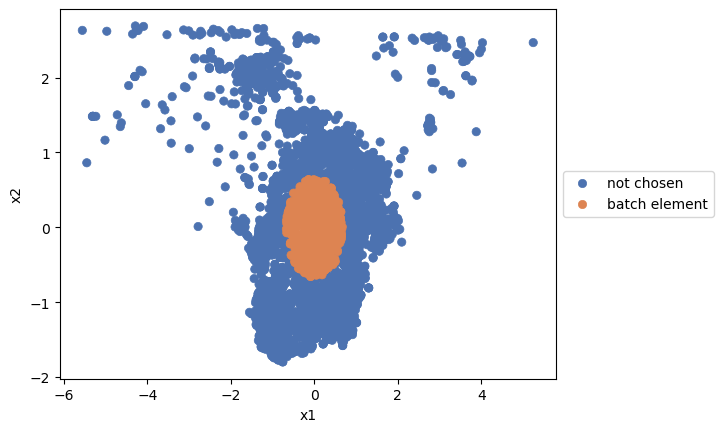

(981,)


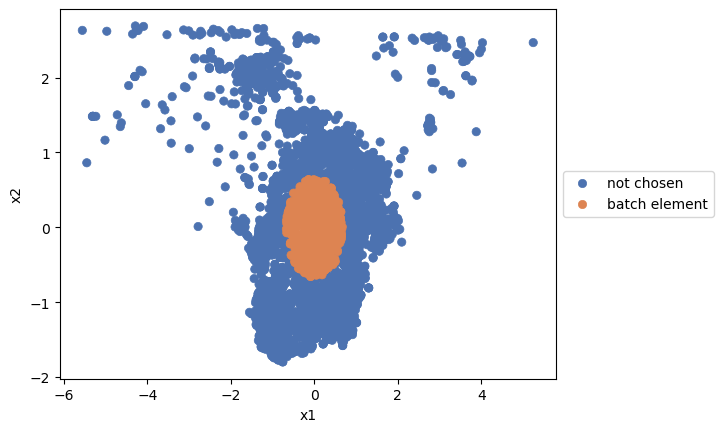

In [137]:
def get_class_embeddings(embeddings, targets, label):
    targets = np.array(targets)
    targets = np.expand_dims(targets, 1)

    full_data = np.append(embeddings, targets, axis=1) 

    class_data = full_data[ full_data[:,-1] == label ]
    class_data = class_data[:,:-1]

    return class_data


#expects data to be in shape (m x d)
def fit_distribution(data_points):
    mu = np.mean(data_points, axis=0)
    covar = np.cov(data_points, rowvar=False)
    diag = np.diagonal(covar)
    sd = np.sqrt(diag)
    new_dist = (class_data - mu)/sd
    return mu, covar, new_dist


import scipy.stats as st
import scipy.linalg
def get_points_outside(dist, percentage=0.5):
    radius = np.abs(st.norm.ppf(percentage/2))
    #print(radius)

    norms = np.linalg.norm(dist, axis=1)
    indexes = np.array(range(0,dist.shape[0]))
    return indexes[ norms > radius]

def get_points_inside(dist, percentage=0.5):
    radius = np.abs(st.norm.ppf((1 - percentage)/2))
    #print(f'radius {radius}')

    norms = np.linalg.norm(dist, axis=1)
    indexes = np.array(range(0,dist.shape[0]))
    return indexes[ norms < radius ]
    

def get_points(dist, percentage=0.5, where='inside'):
    if (where == 'inside'):
        radius = np.abs(st.norm.ppf((1 - percentage)/2))

        norms = np.linalg.norm(dist, axis=1)
        indexes = np.array(range(0,dist.shape[0]))
        return indexes[ norms < radius ]

    elif (where == 'outside'):
        radius = np.abs(st.norm.ppf(percentage/2))

        norms = np.linalg.norm(dist, axis=1)
        indexes = np.array(range(0,dist.shape[0]))
        return indexes[ norms > radius]

    else: 
        raise Exception(f'{where} is not a valid argument')


def fit_distribution_2(data_points):
    mu = np.mean(data_points, axis=0)
    covar = np.cov(data_points, rowvar=False)
    # the following is taken from chatgpt
    centered = data_points - mu
    L = np.linalg.cholesky(covar)
    print(f'cholesky: {L}')

    normalized_data = np.matmul(np.linalg.inv(L), np.transpose(centered))
    normalized_data = normalized_data.T

    normalized_mean = np.mean(normalized_data, axis=0)
    normalized_cov = np.cov(normalized_data, rowvar=False)

    return normalized_mean, normalized_cov, normalized_data


# idea behind this code comes from 
# https://math.stackexchange.com/questions/1652545/multivariate-normal-value-standardization
from sklearn.preprocessing import power_transform
def fit_distribution_3(data_points, transform=True):
    if (transform):
        data_points = power_transform(data_points)

    mu = np.mean(data_points, axis=0)
    sigma = np.cov(data_points, rowvar=False)
    # the following is taken from chatgpt
    centered = data_points - mu
    sigma_inv_sqrt = scipy.linalg.sqrtm(np.linalg.inv(sigma))
    L = sigma_inv_sqrt
    #print(f'simga^(-1/2): {L}')

    normalized_data = np.matmul((L), np.transpose(centered))
    normalized_data = normalized_data.T

    normalized_mean = np.mean(normalized_data, axis=0)
    normalized_cov = np.cov(normalized_data, rowvar=False)

    return normalized_mean, normalized_cov, normalized_data



# returns a list of list of indexes
# each entry in the list contains all the indexes used in that class for the partition
def get_all_partitions(embeddings, targets, labels, percentage, where, transform=False):
    partitions = []
    for l in labels:
        class_data = get_class_embeddings(embeddings, targets, l)
        num_class_points = class_data.shape[0]

        _, _, standardized_data = fit_distribution_3(class_data, transform)

        points = get_points(standardized_data, percentage, where)
        num_points_selected = points.shape[0]

        print(f'{num_points_selected/num_class_points}% points selected for class {l}')
        partitions.append(points)

    return points

        


class_data = get_class_embeddings(image_embeddings, targets, 0)
mu, covar, new_d = fit_distribution_3(class_data, True)

point_indexes = get_points_inside(new_d, 0.50)
print(point_indexes.shape)

plot_batch_elements(new_d, point_indexes)
plt.show()


class_data = get_class_embeddings(image_embeddings, targets, 0)
mu, covar, new_d = fit_distribution_3(class_data, True)

point_indexes = get_points_inside(new_d, 0.50)
print(point_indexes.shape)

plot_batch_elements(new_d, point_indexes)
plt.show()

#class_data = get_class_embeddings(image_embeddings, targets, 3)
#mu, covar, new_d = fit_distribution_2(class_data)

#point_indexes = get_points_inside(new_d, 0.70)
#print(point_indexes.shape)

#plot_batch_elements(new_d, point_indexes)
#plt.show()


In [144]:
labels = np.array(range(0, 10))

get_all_partitions(image_embeddings, targets, labels, 0.73, "inside", True)

0.43966666666666665% points selected for class 0
0.37333333333333335% points selected for class 1
0.4295% points selected for class 2
0.4145% points selected for class 3
0.4225% points selected for class 4
0.3943333333333333% points selected for class 5
0.387% points selected for class 6
0.4043333333333333% points selected for class 7
0.35683333333333334% points selected for class 8
0.39466666666666667% points selected for class 9


array([   1,    3,    6, ..., 5984, 5986, 5997])

In [ ]:
import sys
import numpy
numpy.set_printoptions(threshold = sys.maxsize)
#numpy.set_printoptions(threshold= False)

array([[-7.16059732e+00,  2.78095016e+01],
       [ 8.35239220e+00,  8.35903072e+00],
       [-1.20820551e+01,  7.64734793e+00],
       [-3.26079416e+00,  4.64795876e+01],
       [ 1.18759003e+01,  1.32270622e+01],
       [ 1.23634348e+01, -2.34274006e+01],
       [-1.38986769e+01,  4.61734161e+01],
       [-6.20888186e+00,  4.42574120e+01],
       [ 7.97683811e+00,  3.41643372e+01],
       [-1.32474327e+01,  2.66051445e+01],
       [-4.93348569e-01,  3.87929840e+01],
       [-1.82442150e+01,  2.87323742e+01],
       [ 1.33502826e-01,  3.48543587e+01],
       [-1.92023110e+00,  3.62294693e+01],
       [-1.08413267e+01,  1.99262924e+01],
       [-1.78447990e+01,  2.10453892e+01],
       [ 4.04193764e+01,  4.19582520e+01],
       [ 1.00763884e+01,  4.23118057e+01],
       [-1.12902536e+01,  1.56230659e+01],
       [-5.06329966e+00,  5.59066544e+01],
       [-1.50685911e+01,  3.66109962e+01],
       [ 6.35592365e+00,  3.45967979e+01],
       [ 2.07627220e+01,  3.07974548e+01],
       [-4.

In [68]:
image_embeddings_slice = image_embeddings[:1000][:][:][:]

#distances = calc_distances(image_embeddings_slice)
#sorted_distances = sort_distances(distances)

batch_size = 100

#batch_indexes = generate_indexes_proportional(image_embeddings_slice, sorted_distances, batch_size, seed=None)
#batch_indexes = generate_indexes_proportional_avg(image_embeddings_slice, batch_size)#, seed=1)
batch_indexes = generate_indexes_proportional_avg(image_embeddings_slice, batch_size, power=10, seed=1)

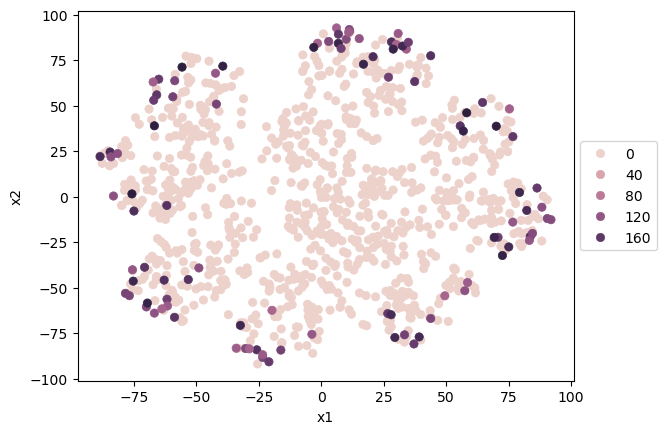

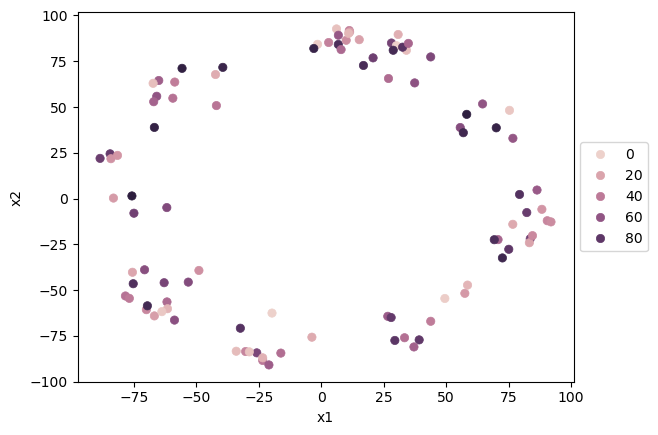

<class 'matplotlib.figure.Figure'>


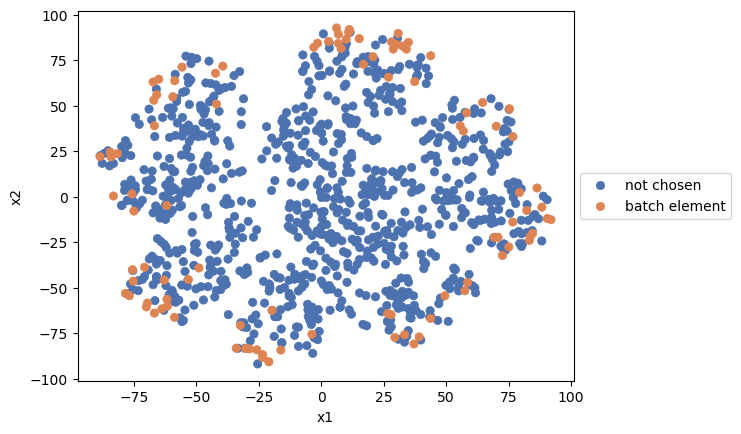

In [69]:
fig1 = plot_batch_order(image_embeddings_slice, batch_indexes, batch_size, type='inclusive')
#plt.close()
plt.show()
fig2 = plot_batch_order(image_embeddings_slice, batch_indexes, batch_size, type='exclusive')
#plt.close()
plt.show()
fig3 = plot_batch_elements(image_embeddings_slice,batch_indexes)
print(type(fig2))
plt.show()

In [ ]:
b = plot_classes_2d(image_embeddings, targets)
